In [1]:
from urllib.request import urlretrieve
from pyopenms import *
gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-extra/master"
urlretrieve (gh + "/src/data/YIC(Carbamidomethyl)DNQDTISSK.mzML", "observed.mzML")

exp = MSExperiment()
# Load mzML file and obtain spectrum for peptide YIC(Carbamidomethyl)DNQDTISSK
MzMLFile().load("observed.mzML", exp)

# Get first spectrum
spectra = exp.getSpectra()
observed_spectrum = spectra[0]

In [2]:
tsg = TheoreticalSpectrumGenerator()
theo_spectrum = MSSpectrum()
p = tsg.getParameters()
p.setValue("add_y_ions", "true")
p.setValue("add_b_ions", "true")
p.setValue("add_metainfo", "true")
tsg.setParameters(p)
peptide = AASequence.fromString("YIC(Carbamidomethyl)DNQDTISSK")
tsg.getSpectrum(theo_spectrum, peptide, 1, 2)

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
    obs_int = [element / max(obs_int) for element in obs_int] # relative intenstiy
    theo_int = [element * -1 for element in theo_int] # invert the intensity for the mirror plot
    plt.figure(figsize=(12,8))
    plt.bar(obs_mz, obs_int, width = 3.0)
    plt.bar(theo_mz, theo_int, width = 3.0)
    plt.title(title)
    plt.ylabel('intensity')
    plt.xlabel('m/z')

obs_mz, obs_int = observed_spectrum.get_peaks()

# The mass-to-charge of our observed spectrum ranges from 200 - 800 m/z
print(min(obs_mz)) # 212.012451171875
print(max(obs_mz)) # 795.2837524414062

# We filter the peaks of the theoretical spectrum to fit the range (to reduce image complexity)
theo_mz, theo_int = [], []
for mz, intensity in zip(*theo_spectrum.get_peaks()):
    if mz >= 200.0 and mz <= 800.0:
        theo_mz.append(mz)
        theo_int.append(intensity)

title = 'Observed vs theoretical spectrum'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

212.012451171875
795.2837524414062


In [4]:
alignment = []
spa = SpectrumAlignment()
p = spa.getParameters()
# use 0.5 Da tolerance (Note: for high-resolution data we could also use ppm by setting the is_relative_tolerance value to true)
p.setValue("tolerance", 0.5)
p.setValue("is_relative_tolerance", "false")
spa.setParameters(p)
# align both spectra
spa.getSpectrumAlignment(alignment, theo_spectrum, observed_spectrum)

In [5]:
# Print matching ions and mz from theoretical spectrum
print("Number of matched peaks: " + str(len(alignment)))
print("ion\ttheo. m/z\tobserved m/z")

for theo_idx, obs_idx in alignment:
    ion_name = theo_spectrum.getStringDataArrays()[0][theo_idx].decode()
    ion_charge = theo_spectrum.getIntegerDataArrays()[0][theo_idx]
    print(ion_name + "\t" + str(ion_charge) + "\t"
      + str(theo_spectrum[theo_idx].getMZ())
      + "\t" + str(observed_spectrum[obs_idx].getMZ()))

Number of matched peaks: 16
ion	theo. m/z	observed m/z
y2+	1	234.14483407287105	234.12303161621094
y5++	2	268.15794163667096	268.1054382324219
b2+	1	277.154670104771	277.24560546875
y3+	1	321.17686323237103	321.2969970703125
y4+	1	434.26092758327104	434.2879638671875
b3+	1	437.185319089971	437.291259765625
y5+	1	535.308606806571	535.18896484375
b4+	1	552.212263249471	552.3375244140625
b9++	2	562.239866948271	562.4213256835938
y10++	2	584.2509635120709	584.4120483398438
y11++	2	640.7929956875209	640.9539184570312
b11++	2	649.2718961077711	649.0973510742188
y6+	1	650.335550966071	650.3652954101562
b5+	1	666.255191440871	666.1763305664062
y7+	1	778.394129221271	778.3391723632812
b6+	1	794.3137696960711	794.192138671875


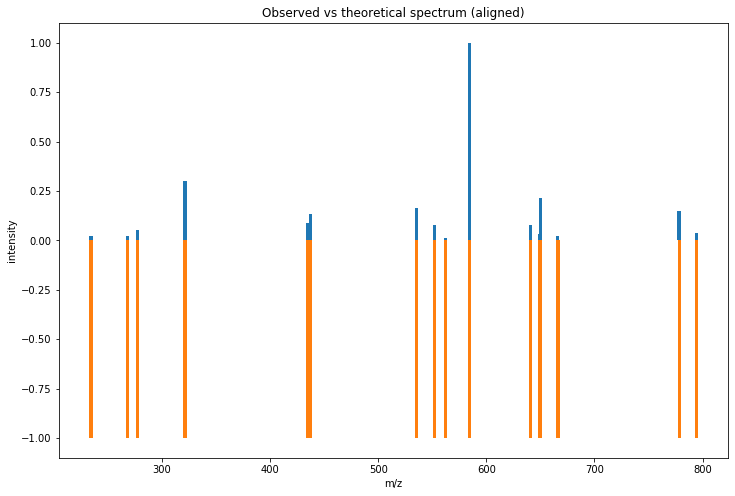

In [6]:
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for theo_idx, obs_idx in alignment:
    theo_mz.append(theo_spectrum[theo_idx].getMZ())
    theo_int.append(theo_spectrum[theo_idx].getIntensity())
    obs_mz.append(observed_spectrum[obs_idx].getMZ())
    obs_int.append(observed_spectrum[obs_idx].getIntensity())

title = 'Observed vs theoretical spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)